In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
import os
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import cross_val_predict
import math

df = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/data/002_data_whole.csv',low_memory=False)

In [2]:
prop = 'caco3'
df.loc[df[f'{prop}_qa']>5,'ref'].unique()#.hist(bins=50,range=[0,50])

array(['portugal.infosolo', 'swiss.nabo', 'Czech', 'LUCAS'], dtype=object)

<Axes: >

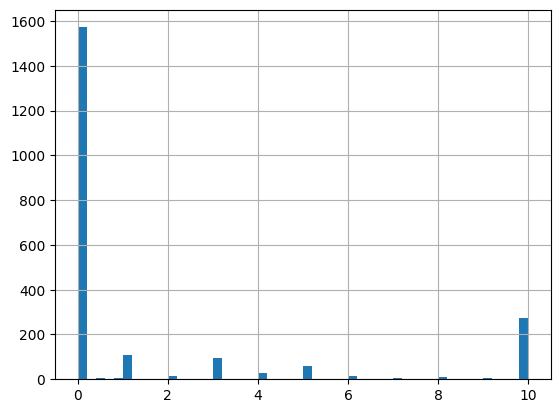

In [3]:
a = df.loc[df['ref'] == 'swiss.nabo']
a[prop].hist(bins=50,range=[0,10])

### get the final model metrics

In [2]:

import pandas as pd

prop_list = ['ph_h2o', 'ph_cacl2', 'oc',  'bulk_density', 'caco3', 'CEC', 'EC', 'P', 'K', 'N']
higher_better = ['R2_val', 'CCC_val', 'R2_cv', 'CCC_cv']
lower_better = ['RMSE_val', 'RMSE_cv'] #, 'cv_time (s)', 'test_time (s)'
best = []

for prop in prop_list:
    dfff = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/results/{prop}/benchmark_metrics_{prop}.csv')
    dfff['property'] = prop

    # Ranking the metrics appropriately
    for col in higher_better:
        dfff[col + '_rank'] = dfff[col].rank(method='min', ascending=False)
        
    for col in lower_better:
        dfff[col + '_rank'] = dfff[col].rank(method='min', ascending=True)
        
    # Sum only the necessary rank columns
    rank_columns = [col + '_rank' for col in higher_better + lower_better]
    dfff['total_rank'] = dfff[rank_columns].sum(axis=1)
    dfff_sorted = dfff.sort_values(by='total_rank')
    best_model = dfff_sorted.iloc[0]

    # Drop rank columns from the best model row
    best_model = best_model.drop(rank_columns + ['total_rank'])

    best.append(best_model)

# Convert best list to DataFrame to view all best models from each property
best_dfff = pd.DataFrame(best)

# Reordering columns to put 'property' first
column_order = ['property'] + [col for col in best_dfff.columns if col != 'property']
best_dfff = best_dfff[column_order]

# print(best_dfff)
best_dfff
# best_dfff.to_csv('/mnt/primus/xuemeng_tmp_harbour/soc/results/benchmark_metrics_predictions.csv',index=False)

,property,title,R2_val,RMSE_val,CCC_val,R2_cv,RMSE_cv,CCC_cv,cv_time (s),test_time (s)
0,ph_h2o,rf,0.749827,0.678042,0.850601,0.620960,0.778612,0.757672,86.111422,101.138331
0,ph_cacl2,rf,0.753294,0.705205,0.853464,0.589844,0.847254,0.735979,76.077030,95.401759
3,oc,rf_weighted,0.525147,0.628680,0.687808,0.594113,0.702021,0.742285,192.808113,231.866860
0,bulk_density,rf,0.287554,0.415276,0.436000,0.394389,0.323545,0.571361,12.090899,13.915060
0,caco3,rf,0.664550,1.276870,0.786341,0.526483,1.427763,0.676199,117.368809,136.043629
3,CEC,rf_weighted,0.379971,0.556320,0.519944,0.345524,0.611173,0.484673,56.066398,66.088224
0,EC,rf,0.349292,0.599538,0.496513,0.443540,0.634188,0.601960,157.518720,184.190601
3,P,rf_weighted,0.284001,0.966067,0.448747,0.300898,0.929050,0.449431,241.577897,287.497012
0,K,rf,0.410260,0.689345,0.562345,0.352556,0.720722,0.511602,264.340473,306.779747
0,N,rf,0.590029,0.420052,0.735055,0.733608,0.446942,0.840313,45.284190,53.858525


### generate production models accordingly

In [3]:

path_list = []
covs_list = []
for prop in prop_list:
    covs_list.append(f'/mnt/primus/xuemeng_tmp_harbour/soc/results/{prop}/benchmark_selected.covs_{prop}.txt')
    
    a = find_files(f'/mnt/primus/xuemeng_tmp_harbour/soc/results/{prop}/','*model*joblib')
    a = [str(i) for i in a]
    model_t = best_dfff.loc[best_dfff['property']==prop,'title'].values[0]
    
    if 'weighted' in model_t:
        model_t = model_t.split('_')[0]
        a = [ii for ii in a if 'weighted' in ii]
    else:
        a = [ii for ii in a if 'weighted' not in ii]

    for ia in a:
        if model_t in ia:
            path_list.append(ia)

In [4]:
path_list

['/mnt/primus/xuemeng_tmp_harbour/soc/results/ph_h2o/model_rf.ph_h2o_normal.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/ph_cacl2/model_rf.ph_cacl2_normal.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/oc/model_rf.oc_log1p.ccc.weighted.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/bulk_density/model_rf.bulk_density_normal.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/caco3/model_rf.caco3_log1p.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/CEC/model_rf.CEC_log1p.ccc.weighted.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/EC/model_rf.EC_log1p.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/P/model_rf.P_log1p.ccc.weighted.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/K/model_rf.K_log1p.ccc.joblib',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/N/model_rf.N_log1p.ccc.joblib']

In [5]:
covs_list

['/mnt/primus/xuemeng_tmp_harbour/soc/results/ph_h2o/benchmark_selected.covs_ph_h2o.txt',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/ph_cacl2/benchmark_selected.covs_ph_cacl2.txt',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/oc/benchmark_selected.covs_oc.txt',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/bulk_density/benchmark_selected.covs_bulk_density.txt',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/caco3/benchmark_selected.covs_caco3.txt',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/CEC/benchmark_selected.covs_CEC.txt',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/EC/benchmark_selected.covs_EC.txt',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/P/benchmark_selected.covs_P.txt',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/K/benchmark_selected.covs_K.txt',
 '/mnt/primus/xuemeng_tmp_harbour/soc/results/N/benchmark_selected.covs_N.txt']

'N'

In [17]:
for covsl in covs_list:
    # covariates
    prop = covsl.split('_')[-1].split('.')[0]
    covs_a = pd.read_csv(covsl).values.tolist()
    covs = [item for sublist in covs_a for item in sublist]
    if 'hzn_dep' in covs:
        iss = 'is'
    else:
        iss = 'is not'
    print(f'feature number of {prop}:', len(covs), f', hzn_dep {iss} in the covariates list')

feature number of h2o: 43 , hzn_dep is in the covariates list
feature number of cacl2: 36 , hzn_dep is in the covariates list
feature number of oc: 43 , hzn_dep is in the covariates list
feature number of density: 28 , hzn_dep is in the covariates list
feature number of caco3: 86 , hzn_dep is in the covariates list
feature number of CEC: 92 , hzn_dep is in the covariates list
feature number of EC: 81 , hzn_dep is in the covariates list
feature number of P: 83 , hzn_dep is in the covariates list
feature number of K: 80 , hzn_dep is in the covariates list
feature number of N: 23 , hzn_dep is in the covariates list


In [6]:
import shutil
n_jobs=90
for ii in range(len(covs_list)):
    # target property
    prop = prop_list[ii]
    print(f'process {prop}')
    # model
    model = joblib.load(path_list[ii])
    namef = 'propduction.' + path_list[ii].split('/')[-1]
    # update model's n_jobs
    if hasattr(model, 'steps'):  # Check if it's a Pipeline
        for name, estimator in model.steps:
            if hasattr(estimator, 'n_jobs'):
                estimator.n_jobs = n_jobs
                print(f"Updated n_jobs to {n_jobs} for '{name}' in the pipeline.")
    elif hasattr(model, 'n_jobs'):  # Check if it's a model with n_jobs
        model.n_jobs = n_jobs
        print(f"Updated n_jobs to {n_jobs} for model {namef}.")
    else:
        print("This object does not support the 'n_jobs' parameter.")
        
    # covariates
    covs_a = pd.read_csv(covs_list[ii]).values.tolist()
    covs = [item for sublist in covs_a for item in sublist]
    
    # all the data
    dff = df.dropna(subset=covs+[prop],how='any')
    
    # fit the model
    model.fit(dff[covs],dff[prop])
    joblib.dump(model,f'/mnt/primus/xuemeng_tmp_harbour/soc/results/production_model/{namef}')
    # shutil.copy(covs_list[ii], covs_list[ii].replace(f'results/{prop}','results/production_model'))

process ph_h2o
Updated n_jobs to 90 for model propduction.model_rf.ph_h2o_normal.ccc.joblib.
process ph_cacl2
Updated n_jobs to 90 for model propduction.model_rf.ph_cacl2_normal.ccc.joblib.
process oc
Updated n_jobs to 90 for model propduction.model_rf.oc_log1p.ccc.weighted.joblib.
process bulk_density
Updated n_jobs to 90 for model propduction.model_rf.bulk_density_normal.ccc.joblib.
process caco3
Updated n_jobs to 90 for model propduction.model_rf.caco3_log1p.ccc.joblib.
process CEC
Updated n_jobs to 90 for model propduction.model_rf.CEC_log1p.ccc.weighted.joblib.
process EC
Updated n_jobs to 90 for model propduction.model_rf.EC_log1p.ccc.joblib.
process P
Updated n_jobs to 90 for model propduction.model_rf.P_log1p.ccc.weighted.joblib.
process K
Updated n_jobs to 90 for model propduction.model_rf.K_log1p.ccc.joblib.
process N
Updated n_jobs to 90 for model propduction.model_rf.N_log1p.ccc.joblib.


In [ ]:
best_df

<Axes: >

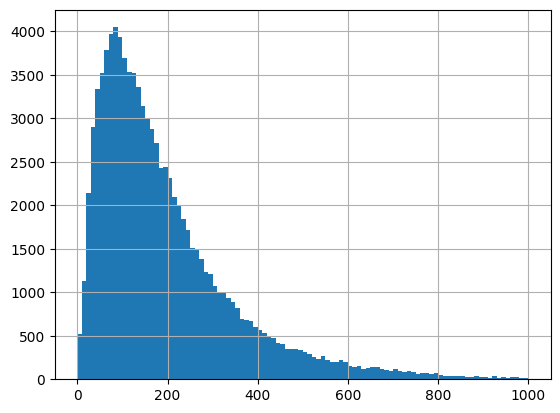

In [69]:
prop = 'K'
df[prop].hist(bins=100,range=[0,1000])

In [77]:
df.loc[df[prop]>20000]#['ref'].unique()

,id,lat,lon,time,ref,nuts0,oc,ph_h2o,ph_cacl2,bulk_density,...,lithology_EGDI_syenite,lithology_EGDI_tephrite,lithology_EGDI_tonalite,lithology_EGDI_trachyte,lithology_EGDI_trachytoid,lithology_EGDI_tuffBrecciaAgglomerateOrPyroclasticBreccia,lithology_EGDI_ultramaficIgneousRock,lithology_EGDI_wacke,lithology_EGDI_Unpopulated,hzn_dep
25321,1656,46.762463,9.795503,2000.0,swiss.nabo,CH,42.761455,4.94,4.94,0.866723,...,0,0,0,0,0,0,0,0,0,10.0
25322,1657,46.756161,9.802142,2000.0,swiss.nabo,CH,69.072366,5.02,5.02,0.730051,...,0,0,0,0,0,0,0,0,0,10.0
25324,1661,46.678121,9.667501,2000.0,swiss.nabo,CH,48.846188,6.95,6.95,0.766384,...,0,0,0,0,0,0,0,0,0,10.0
25326,1663,46.950150,9.580364,2000.0,swiss.nabo,CH,40.445490,7.51,7.51,0.904924,...,0,0,0,0,0,0,0,0,0,10.0
37037,1626,46.234423,9.104502,2001.0,swiss.nabo,CH,21.000000,4.71,4.71,1.096859,...,0,0,0,0,0,0,0,0,0,10.0
37041,1629,46.366407,9.127164,2001.0,swiss.nabo,CH,19.000000,4.35,4.35,1.119525,...,0,0,0,0,0,0,0,0,0,10.0
37048,1668,46.739702,9.105741,2001.0,swiss.nabo,CH,49.800000,4.54,4.54,0.880136,...,0,0,0,0,0,0,0,0,0,10.0
37049,1669,46.749354,9.453856,2001.0,swiss.nabo,CH,48.214290,7.12,7.12,1.054329,...,0,0,0,0,0,0,0,0,0,10.0
37053,1673,46.631846,9.400657,2001.0,swiss.nabo,CH,54.200000,4.81,4.81,0.823854,...,0,0,0,0,0,0,0,0,0,10.0
37054,1674,46.618949,9.346280,2001.0,swiss.nabo,CH,55.000000,5.86,5.86,0.857301,...,0,0,0,0,0,0,0,0,0,10.0


In [61]:
df[prop].max()

9.86

In [65]:
best_dfff#['property', 'title', 'R2_val', 'RMSE_val', 'CCC_val', 'R2_cv','RMSE_cv', 'CCC_cv', 'cv_time (s)', 'test_time (s)']

,property,title,R2_val,RMSE_val,CCC_val,R2_cv,RMSE_cv,CCC_cv,cv_time (s),test_time (s)
0,oc,rf,0.521929,0.631190,0.686796,0.584845,0.709827,0.736924,114.771056,136.970790
0,ph_h2o,rf,0.733580,0.699773,0.840577,0.603598,0.795962,0.747076,81.725859,58.499077
3,ph_cacl2,rf_weighted,0.759816,0.695820,0.858062,0.598751,0.838302,0.743977,137.373652,134.724805
3,bulk_density,rf_weighted,0.279815,0.417525,0.424275,0.356616,0.333586,0.540507,6.947836,7.106372
4,caco3,lgb_weighted,0.659061,1.287274,0.787558,0.529153,1.427255,0.686390,8.254335,0.615786
3,CEC,rf_weighted,0.406325,0.544544,0.541953,0.379794,0.594566,0.520019,87.544101,102.824505
0,EC,rf,0.365355,0.592491,0.512382,0.464276,0.622446,0.621897,269.255990,292.663614
3,P,rf_weighted,0.289630,0.962262,0.453291,0.301582,0.929909,0.447963,318.177178,372.809715
0,K,rf,0.424477,0.680985,0.573106,0.369374,0.708407,0.526689,650.003211,753.320741
3,N,rf_weighted,0.590117,0.420008,0.735299,0.729614,0.451402,0.839741,48.048637,56.602144


In [67]:
best_dfff.rename(columns={'title':'final_model'})

,property,final_model,R2_val,RMSE_val,CCC_val,R2_cv,RMSE_cv,CCC_cv,cv_time (s),test_time (s)
0,oc,rf,0.521929,0.631190,0.686796,0.584845,0.709827,0.736924,114.771056,136.970790
0,ph_h2o,rf,0.733580,0.699773,0.840577,0.603598,0.795962,0.747076,81.725859,58.499077
3,ph_cacl2,rf_weighted,0.759816,0.695820,0.858062,0.598751,0.838302,0.743977,137.373652,134.724805
3,bulk_density,rf_weighted,0.279815,0.417525,0.424275,0.356616,0.333586,0.540507,6.947836,7.106372
4,caco3,lgb_weighted,0.659061,1.287274,0.787558,0.529153,1.427255,0.686390,8.254335,0.615786
3,CEC,rf_weighted,0.406325,0.544544,0.541953,0.379794,0.594566,0.520019,87.544101,102.824505
0,EC,rf,0.365355,0.592491,0.512382,0.464276,0.622446,0.621897,269.255990,292.663614
3,P,rf_weighted,0.289630,0.962262,0.453291,0.301582,0.929909,0.447963,318.177178,372.809715
0,K,rf,0.424477,0.680985,0.573106,0.369374,0.708407,0.526689,650.003211,753.320741
3,N,rf_weighted,0.590117,0.420008,0.735299,0.729614,0.451402,0.839741,48.048637,56.602144
